In [14]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import os
import librosa
import librosa.display
# import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [15]:
df = pd.read_csv('audio_data_path.csv')
df.head()

,Emotions,Path
0,sad,ravedess/audio_speech_actors_01-24/Actor_11/03...
1,calm,ravedess/audio_speech_actors_01-24/Actor_11/03...
2,disgust,ravedess/audio_speech_actors_01-24/Actor_11/03...
3,surprise,ravedess/audio_speech_actors_01-24/Actor_11/03...
4,calm,ravedess/audio_speech_actors_01-24/Actor_11/03...


In [3]:
df['Emotions'].value_counts()

Emotions
sad         1923
disgust     1923
happy       1923
fear        1923
angry       1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64

In [4]:
filename = df['Path'][1]
data,sample_rate=librosa.load(filename)

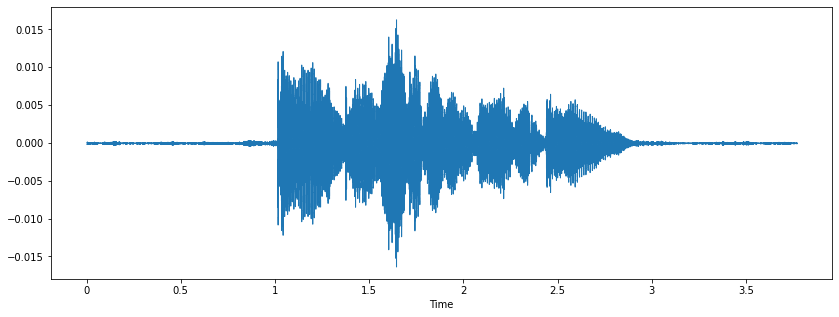

In [5]:
plt.figure(figsize=(14,5))
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

In [6]:
sample_rate

22050

In [7]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio=wav.read(filename)

/tmp/ipykernel_16621/1160942666.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wave_sample_rate, wave_audio=wav.read(filename)


In [8]:
wave_sample_rate

48000

In [9]:
wave_audio

array([-5, -4, -4, ..., -1,  0,  0], dtype=int16)

Mono channel

In [10]:
df['Emotions'].value_counts()

Emotions
sad         1923
disgust     1923
happy       1923
fear        1923
angry       1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64

In [11]:
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 163)


In [12]:
mfccs

array([[-8.8300391e+02, -8.8894824e+02, -9.1038031e+02, ...,
        -9.0006787e+02, -9.1218951e+02, -9.4612994e+02],
       [ 7.1773254e+01,  4.4210419e+01,  2.7713692e+01, ...,
         2.6707100e+01,  2.5666897e+01,  2.3730938e+01],
       [ 3.1932613e+01,  3.0541584e+01,  2.0858444e+01, ...,
         2.3791512e+01,  2.0571321e+01,  1.8999506e+01],
       ...,
       [ 3.7898998e+00,  4.4681902e+00,  6.5715802e-01, ...,
         1.8726039e+00,  3.5137143e+00,  8.0099468e+00],
       [ 1.4865909e+00,  2.2726438e+00, -1.1948690e+00, ...,
         4.3146987e+00, -6.3679039e-01,  4.2157860e+00],
       [-6.6467881e-01, -2.9668307e-01, -1.4553505e+00, ...,
         1.1911914e+00,  9.0706909e-01,  2.6495228e+00]], dtype=float32)

In [16]:
def noise(data):
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=1.0):
    return librosa.effects.time_stretch(data, rate=rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr = sampling_rate, n_steps = pitch_factor)


In [17]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, hop_length=hop_length)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
#     
    return audio

In [18]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  16


In [19]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(df.Path,df.Emotions,range(df.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)      

1it [00:00,  6.19it/s]

0 audio has been processed


502it [00:52,  9.72it/s]

500 audio has been processed


1002it [01:43,  9.91it/s]

1000 audio has been processed


1502it [02:34, 11.65it/s]

1500 audio has been processed


2003it [03:19, 10.76it/s]

2000 audio has been processed


2503it [04:05, 10.77it/s]

2500 audio has been processed


3003it [04:51, 11.61it/s]

3000 audio has been processed


3503it [05:36, 11.41it/s]

3500 audio has been processed


4001it [06:22, 10.17it/s]

4000 audio has been processed


4503it [07:07, 11.20it/s]

4500 audio has been processed


5003it [07:53, 10.86it/s]

5000 audio has been processed


5502it [08:40, 10.54it/s]

5500 audio has been processed


6002it [09:27, 11.48it/s]

6000 audio has been processed


6503it [10:12, 11.22it/s]

6500 audio has been processed


7001it [10:59, 12.12it/s]

7000 audio has been processed


7502it [11:46,  9.40it/s]

7500 audio has been processed


8003it [12:32, 11.38it/s]

8000 audio has been processed


8502it [13:19, 10.37it/s]

8500 audio has been processed


9004it [14:02, 17.24it/s]

9000 audio has been processed


9502it [14:35, 13.93it/s]

9500 audio has been processed


10002it [15:15, 13.69it/s]

10000 audio has been processed


10502it [15:59, 13.34it/s]

10500 audio has been processed


11002it [16:39, 11.12it/s]

11000 audio has been processed


11502it [17:17, 15.14it/s]

11500 audio has been processed


12002it [18:04,  8.59it/s]

12000 audio has been processed


12162it [18:22, 11.03it/s]

Done
Time:  1102.3333272519994


In [22]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion4.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.055176,0.095215,0.160156,0.213867,0.262207,0.312500,0.348145,0.361328,0.365234,0.349121,...,1.017847,1.011451,1.003673,0.994527,0.984050,0.972249,0.959179,0.944863,0.929345,sad
1,0.113281,0.181641,0.273926,0.316406,0.345215,0.370117,0.375488,0.372070,0.370117,0.382324,...,3.387598,4.066836,6.973920,2.352084,2.447948,-0.956190,4.410006,2.127808,0.108541,sad
2,0.034180,0.066406,0.130371,0.196289,0.271484,0.328613,0.368652,0.388184,0.382812,0.373535,...,1.705197,1.698357,1.690013,1.680189,1.668895,1.656147,1.641968,1.626385,1.609414,sad
3,0.073242,0.120117,0.188965,0.254883,0.305176,0.351074,0.387207,0.396484,0.398438,0.402344,...,0.031623,0.044344,5.272876,3.203002,0.495236,-1.108803,0.711020,7.512552,3.949652,sad
4,0.000000,0.000000,0.000000,0.006836,0.006836,0.006836,0.083496,0.076660,0.076660,0.076660,...,16.396500,13.472528,10.924034,6.113907,0.031529,8.286678,14.161294,9.829187,1.385454,calm


In [16]:
Emotions = pd.read_csv('./emotion4.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.055176,0.095215,0.160156,0.213867,0.262207,0.312500,0.348145,0.361328,0.365234,0.349121,...,1.017847,1.011451,1.003673,0.994527,0.984050,0.972249,0.959179,0.944863,0.929345,sad
1,0.113281,0.181641,0.273926,0.316406,0.345215,0.370117,0.375488,0.372070,0.370117,0.382324,...,3.387598,4.066836,6.973920,2.352084,2.447948,-0.956190,4.410006,2.127808,0.108541,sad
2,0.034180,0.066406,0.130371,0.196289,0.271484,0.328613,0.368652,0.388184,0.382812,0.373535,...,1.705197,1.698357,1.690013,1.680189,1.668895,1.656147,1.641968,1.626385,1.609414,sad
3,0.073242,0.120117,0.188965,0.254883,0.305176,0.351074,0.387207,0.396484,0.398438,0.402344,...,0.031623,0.044344,5.272876,3.203002,0.495236,-1.108803,0.711020,7.512552,3.949652,sad
4,0.000000,0.000000,0.000000,0.006836,0.006836,0.006836,0.083496,0.076660,0.076660,0.076660,...,16.396500,13.472528,10.924034,6.113907,0.031529,8.286678,14.161294,9.829187,1.385454,calm
